<a href="https://colab.research.google.com/github/mmbaye/SoilMoisutre_Demo/blob/main/demo_Soil_Moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration on soil moisture retrieval based on sentinel1

we will work on step by step code on building a calibrated soil moisture conversion modele 
based on C-band sentinel1 data around field sampling in petzenkirchen in vienna austria. 
we will use google http://colab.to/r  to run the script
we will also use google earth engine to  process sentinel 1 data 

In [ ]:
library(tidyverse)
library(lubridate)

In [ ]:
install.packages('patchwork')
install.packages('caret')

In [27]:
library(patchwork)
library(caret)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




# step 1 : process Cosmic-Ray neutron Sensor In-situ data

In [10]:
df<-read.csv('/content/sample_data/crns2020.txt')

colvars<-c("UTC", "N1" ,"N2" , "P1","Battery","H7","T7","P4","D1", "NMcounts","fbar","fhum","fsol", "VWC", "BM" ,"periods")
varnames<-colvars[c(1:3,14)]

In [11]:
df<-df %>% set_names(colvars) %>% filter(VWC>0) %>% 
    select(c(1:3,14)) %>% 
    mutate(UTC=as.Date(UTC),Year=year(UTC), Months=month(UTC, label = T))

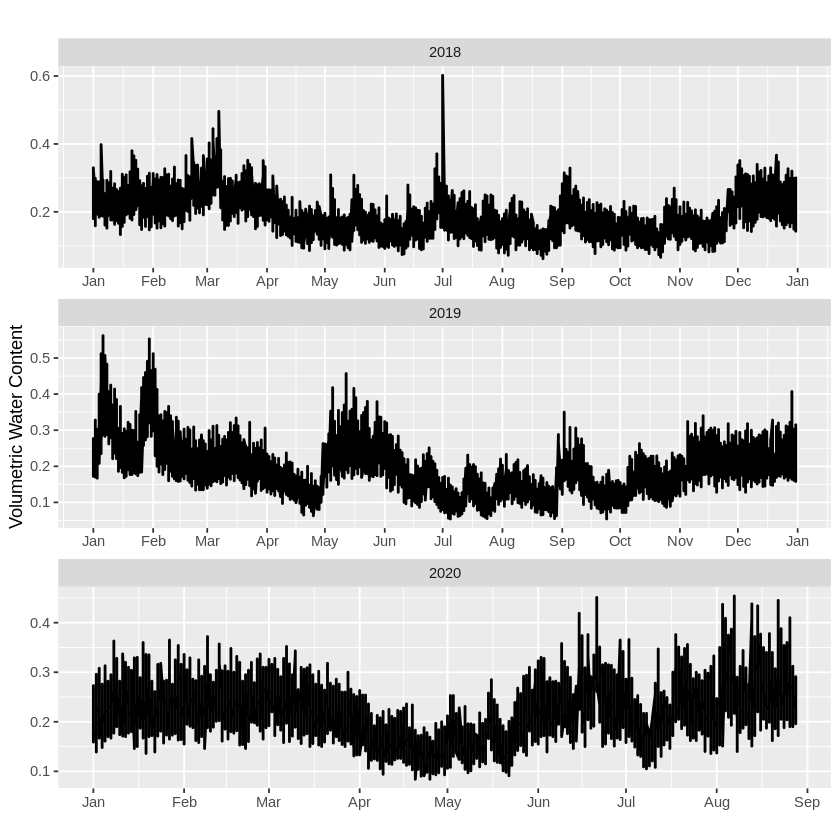

In [12]:
df %>% 
  filter(Year %in% c(2018,2019,2020)) %>% 
  ggplot(aes(x=UTC)) + 
  geom_line(aes(y=VWC), show.legend = F,size=0.8) +
  facet_wrap(~year(UTC), scales = 'free', nrow =3)+
  scale_x_date(date_breaks = '1 month', date_labels = '%b')+
  labs(y='Volumetric Water Content',x='',title = '') ->p1


p1

# step 2  Sentinel 1 time-serie datasets


In [13]:
 radar <-'/content/sample_data/sigmaVVboxcar100.csv' %>% read.csv() %>% mutate(UTC=mdy(Time)) %>% select(c(2,3))

In [ ]:
head(radar)


In [16]:
df<-df %>% group_by(UTC) %>% summarise(VWC=mean(VWC)) %>% as.data.frame
df.merge<-df %>% inner_join(radar, by='UTC') %>% filter(VWC<=0.4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



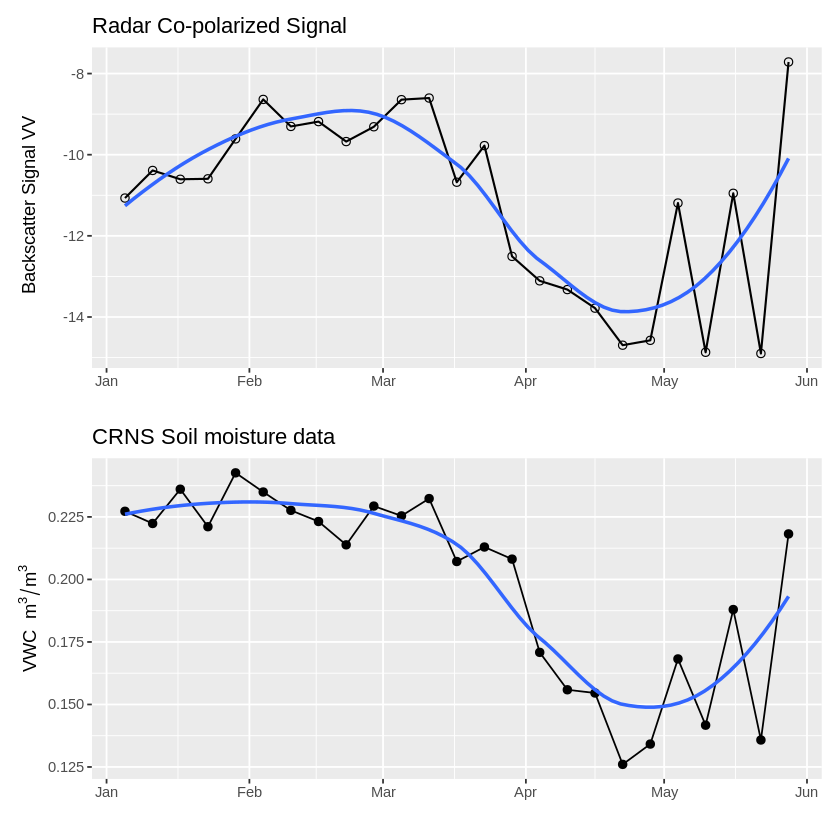

In [26]:
p3<-df.merge %>% 
  filter(UTC>=ymd(20200101) & UTC<=ymd(20200601)) %>% 
  ggplot(aes(UTC,VV)) +
  geom_point(size=2,shape=21)+
  geom_line(size=0.6)+
  geom_smooth(se = F) +
  labs(title = 'Radar Co-polarized Signal' , x='',y=' Backscatter Signal VV')  

p4<-df.merge %>%
  filter(UTC>=ymd(20200101) & UTC<=ymd(20200601)) %>% 
  ggplot(aes(UTC,VWC)) +
  geom_point(size=2)+
  geom_line()+
  geom_smooth(se = F)+
  labs(title = 'CRNS Soil moisture data' , x='',y=bquote('VWC'~m^3/m^3)) 

  p3/p4

# Model calibration to estimate linear model parameters

In [29]:

# calibration -------------------------------------------------------------
dts<-df.merge %>%  
  filter(UTC>=ymd(20200101) & UTC<=ymd(20200601)) %>% 
  select(c(3,2))
x<-dts$VV
y<-dts$VWC

# training model ----------------------------------------------------------
mod<-lm(y~x)
mod
summary(mod)
# validation and prediction -----------------------------------------------




Call:
lm(formula = y ~ x)

Coefficients:
(Intercept)            x  
    0.36759      0.01524  



Call:
lm(formula = y ~ x)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.031821 -0.008657 -0.002968  0.003643  0.031127 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.367593   0.017227   21.34  < 2e-16 ***
x           0.015240   0.001522   10.01 7.44e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0166 on 23 degrees of freedom
Multiple R-squared:  0.8134,	Adjusted R-squared:  0.8053 
F-statistic: 100.3 on 1 and 23 DF,  p-value: 7.445e-10


In [32]:

observed.train<-dts$VWC
predicted.train<-predict(mod,dts)
observed.val<-df.merge$VWC
predicted.val<-(mod$coefficients[2]*df.merge$VV  + mod$coefficients[1])

rmse.val<-caret::RMSE(observed.val,predicted.val)
rmse.train<-caret::RMSE(observed.train,predicted.train)

round(rmse.train,3)

# plots -----------------------------------------------------------------

[1] 0.016

In [33]:
myplot<-function(x,y){
  axisRange.val <- extendrange(c(x,y))
  plot(x,
       y,
       cex.lab=1.2,cex=2,
       las=1,cex.axis=1.2,
       cex.main=1.5,
       font.axis=2, font.main=4,
       font.lab=2,
       ylim = axisRange.val,
       xlim = axisRange.val,
       pch=19)
  abline(0, 1, col = "black", lty = 1,lwd=2)
}



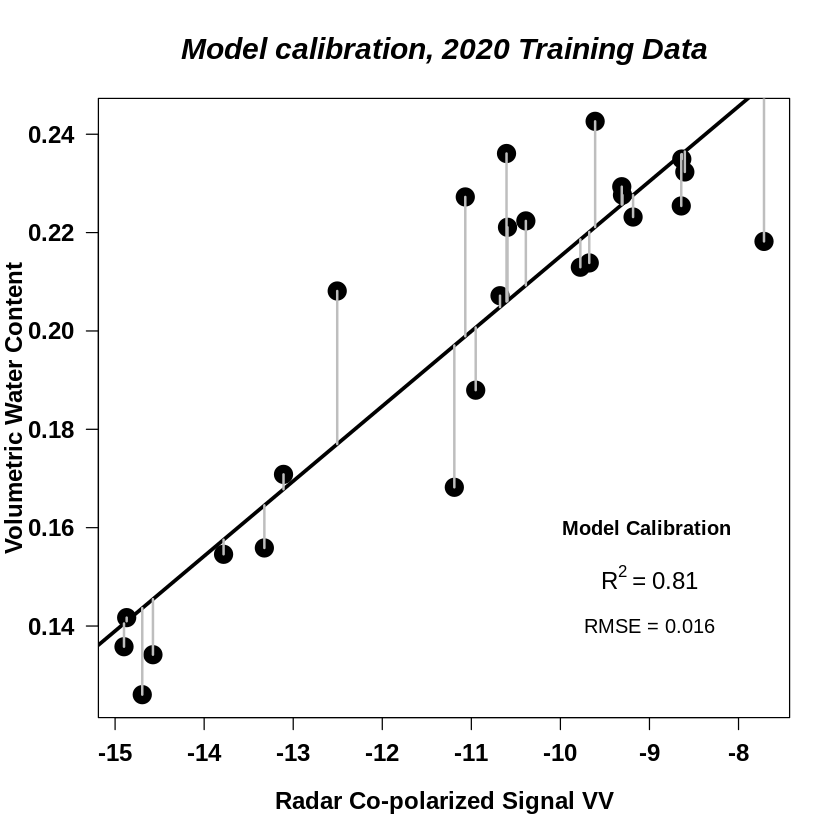

In [35]:
# plotting ----------------------------------------------------------------

plot(x,y, pch=19,col='black',
     cex.lab=1.2,cex=2,las=1,cex.axis=1.2,cex.main=1.5,
     font.axis=2, font.main=4, font.lab=2,
     main = 'Model calibration, 2020 Training Data',
     ylab='Volumetric Water Content', 
     xlab="Radar Co-polarized Signal VV")
abline(mod, lwd=3, col='black')
segments(x,fitted(mod),x,y,lwd=2,col='grey',lty=1)
text(-9, 0.16,labels=c('Model Calibration '), cex=1, font=2)
text(-9, 0.15,labels=bquote(R^2==0.81), cex=1.2, font=2)
text(-9, 0.14,labels='RMSE = 0.016', cex=1, font=1)


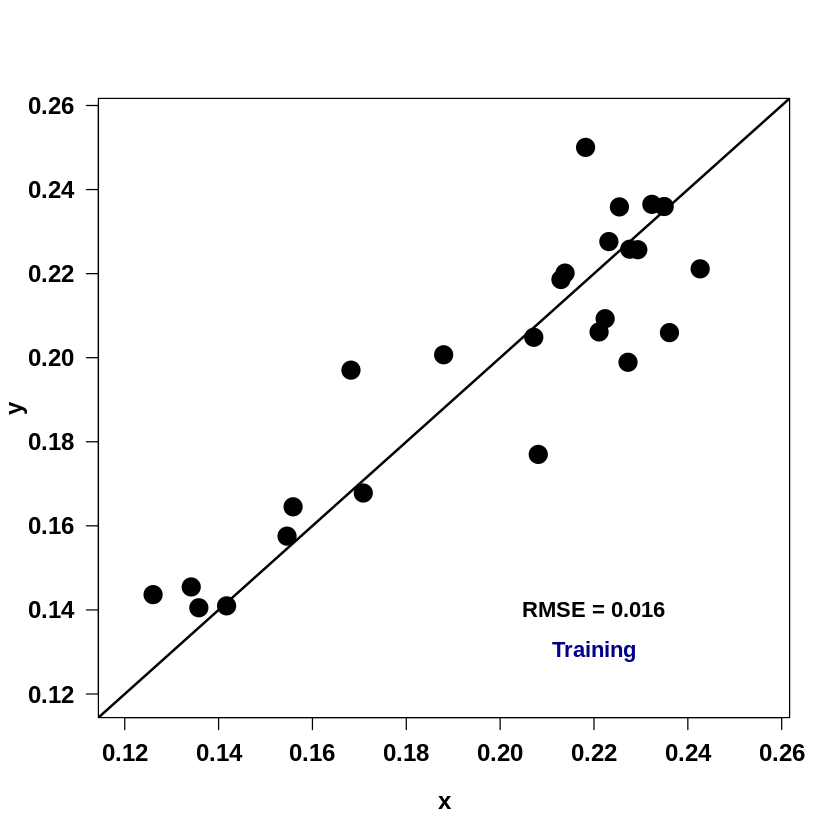

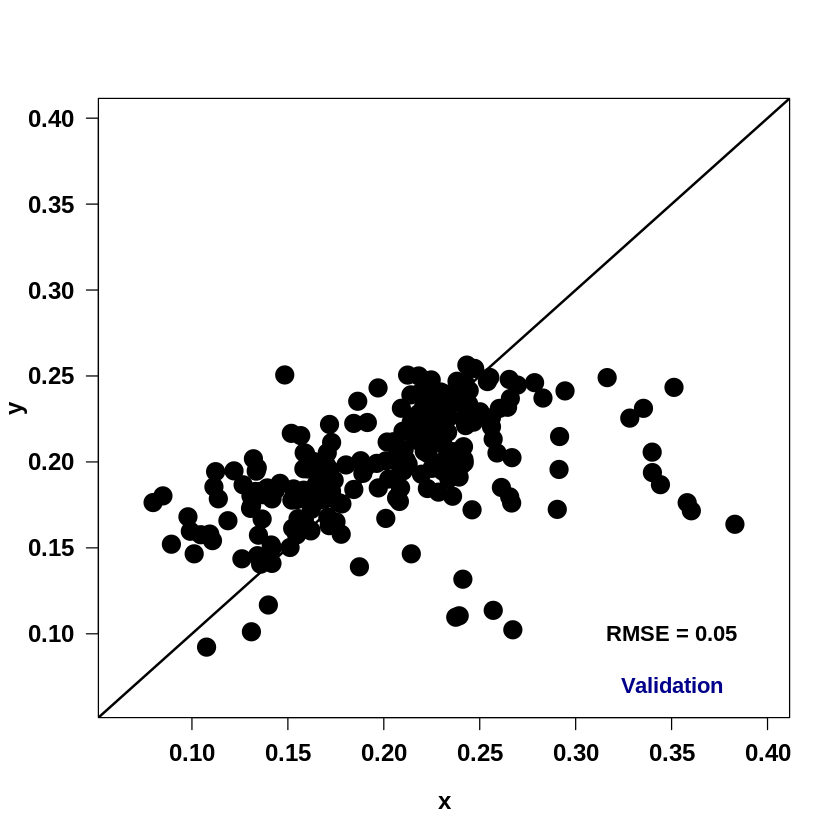

In [36]:

# plot2 -------------------------------------------------------------------


myplot(observed.train,predicted.train)
text(0.22, 0.14,labels=paste0('RMSE = ', round(rmse.train,3)), cex=1.1, font=2)
text(0.22, 0.13,labels='Training', cex=1.1, font=2,col='darkblue')


myplot(observed.val,predicted.val)
text(0.35, 0.10,labels=paste0('RMSE = ', round(rmse.val,3)), cex=1.1, font=2)
text(0.35, 0.07,labels='Validation', cex=1.1, font=2,col='darkblue')